In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import gc
import pydicom
import math
import warnings
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset

!pip install '/kaggle/input/hengck23-ver-1-demo-workflow-2-stage-approach/natsort-8.4.0-py3-none-any.whl'

import sys, os
sys.path.append('/kaggle/input/hengck23-ver-1-demo-workflow-2-stage-approach')

from _dir_setting_ import *

import matplotlib
import matplotlib.pyplot as plt

from helper import *
from data import *

import sys
sys.path.append("/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master/")
sys.path.append("/kaggle/input/pretrainedmodels-0-7-4/pretrainedmodels-0.7.4")
sys.path.append("/kaggle/input/efficientnet-pytorch-0-7-1/efficientnet_pytorch-0.7.1")
import efficientnet_pytorch
import pretrainedmodels
import segmentation_models_pytorch as smp
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Processing /kaggle/input/hengck23-ver-1-demo-workflow-2-stage-approach/natsort-8.4.0-py3-none-any.whl


/kaggle/input/pretrainedmodels-0-7-4/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/kaggle/input/pretrainedmodels-0-7-4/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/kaggle/input/pretrainedmodels-0-7-4/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


In [2]:
DEBUG = False
N = 100 # 0 for all

In [3]:
# Swiss Army Knife model
Sagittal_T1_sagittal_segmentation_paths = [
        '/kaggle/input/sagittal-t1/Sagittal_T1_sagittal_level_segmentation_1',
        '/kaggle/input/sagittal-t1/Sagittal_T1_sagittal_level_segmentation_2',
        '/kaggle/input/sagittal-t1/Sagittal_T1_sagittal_level_segmentation_3',
        '/kaggle/input/sagittal-t1/Sagittal_T1_sagittal_level_segmentation_4',
        '/kaggle/input/sagittal-t1/Sagittal_T1_sagittal_level_segmentation_5'
]
Axial_T2_axial_segmentation_paths = [
        '/kaggle/input/axial-t2/Axial_T2_axial_side_segmentation_1',
        '/kaggle/input/axial-t2/Axial_T2_axial_side_segmentation_2',
        '/kaggle/input/axial-t2/Axial_T2_axial_side_segmentation_3',
        '/kaggle/input/axial-t2/Axial_T2_axial_side_segmentation_4',
        '/kaggle/input/axial-t2/Axial_T2_axial_side_segmentation_5'
]
Sagittal_T2_sagittal_segmentation_paths = [
        '/kaggle/input/sagittal-t2/Sagittal_T2_sagittal_level_segmentation_1',
        '/kaggle/input/sagittal-t2/Sagittal_T2_sagittal_level_segmentation_2',
        '/kaggle/input/sagittal-t2/Sagittal_T2_sagittal_level_segmentation_3',
        '/kaggle/input/sagittal-t2/Sagittal_T2_sagittal_level_segmentation_4',
        '/kaggle/input/sagittal-t2/Sagittal_T2_sagittal_level_segmentation_5'
]
Sagittal_T1_foraminal_paths = [
    '/kaggle/input/sagittal-t1/Sagittal_T1_pretrained_foraminal_ViT_1',
    '/kaggle/input/sagittal-t1/Sagittal_T1_pretrained_foraminal_ViT_2',
    '/kaggle/input/sagittal-t1/Sagittal_T1_pretrained_foraminal_ViT_3',
    '/kaggle/input/sagittal-t1/Sagittal_T1_pretrained_foraminal_ViT_4',
    '/kaggle/input/sagittal-t1/Sagittal_T1_pretrained_foraminal_ViT_5'
]
Sagittal_T2_spinal_paths = [
    '/kaggle/input/sagittal-t2/Sagittal_T2_Spinal_ViT_1',
    '/kaggle/input/sagittal-t2/Sagittal_T2_Spinal_ViT_2',
    '/kaggle/input/sagittal-t2/Sagittal_T2_Spinal_ViT_3',
    '/kaggle/input/sagittal-t2/Sagittal_T2_Spinal_ViT_4',
    '/kaggle/input/sagittal-t2/Sagittal_T2_Spinal_ViT_5'
]
Axial_T2_subarticular_paths = [
    '/kaggle/input/subarticular-dicom-v2-vit/subarticular_DICOM_V2_ViT_1',
    '/kaggle/input/subarticular-dicom-v2-vit/subarticular_DICOM_V2_ViT_2',
    '/kaggle/input/subarticular-dicom-v2-vit/subarticular_DICOM_V2_ViT_3',
    '/kaggle/input/subarticular-dicom-v2-vit/subarticular_DICOM_V2_ViT_4',
    '/kaggle/input/subarticular-dicom-v2-vit/subarticular_DICOM_V2_ViT_5'
]
Axial_T2_spinal_paths = [
    '/kaggle/input/subarticular-dicom-v2-vit/spinal_DICOM_ViT_1.pth',
    '/kaggle/input/subarticular-dicom-v2-vit/spinal_DICOM_ViT_2.pth',
    '/kaggle/input/subarticular-dicom-v2-vit/spinal_DICOM_ViT_3.pth',
    '/kaggle/input/subarticular-dicom-v2-vit/spinal_DICOM_ViT_4.pth',
    '/kaggle/input/subarticular-dicom-v2-vit/spinal_DICOM_ViT_5.pth'
]
# Definitions
spinal = [
    'spinal_canal_stenosis_l1_l2',
    'spinal_canal_stenosis_l2_l3',
    'spinal_canal_stenosis_l3_l4',
    'spinal_canal_stenosis_l4_l5',
    'spinal_canal_stenosis_l5_s1'
]
lforaminal = [
    'left_neural_foraminal_narrowing_l1_l2',
    'left_neural_foraminal_narrowing_l2_l3',
    'left_neural_foraminal_narrowing_l3_l4',
    'left_neural_foraminal_narrowing_l4_l5',
    'left_neural_foraminal_narrowing_l5_s1'
]
rforaminal = [
    'right_neural_foraminal_narrowing_l1_l2',
    'right_neural_foraminal_narrowing_l2_l3',
    'right_neural_foraminal_narrowing_l3_l4',
    'right_neural_foraminal_narrowing_l4_l5',
    'right_neural_foraminal_narrowing_l5_s1'
]
lsubarticular = [
    'left_subarticular_stenosis_l1_l2',
    'left_subarticular_stenosis_l2_l3',
    'left_subarticular_stenosis_l3_l4',
    'left_subarticular_stenosis_l4_l5',
    'left_subarticular_stenosis_l5_s1'
]
rsubarticular = [
    'right_subarticular_stenosis_l1_l2',
    'right_subarticular_stenosis_l2_l3',
    'right_subarticular_stenosis_l3_l4',
    'right_subarticular_stenosis_l4_l5',
    'right_subarticular_stenosis_l5_s1'
]
foraminal = lforaminal + rforaminal
subarticular = lsubarticular + rsubarticular
diagnosis = spinal + foraminal + subarticular
coor = [
    'x_L1L2',
    'y_L1L2',
    'x_L2L3',
    'y_L2L3',
    'x_L3L4',
    'y_L3L4',
    'x_L4L5',
    'y_L4L5',
    'x_L5S1',
    'y_L5S1'
]

In [4]:
if DEBUG:
    TEST_PATH = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/'
    test_description = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
    if N > 0: test_description = test_description[:N]
    test_description.head()
    TEST = False
else:
    TEST_PATH = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'
    test_description = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv')
    test_description.head()
    TEST = True

# Preprocessing

In [5]:
PATCH_H = 512
PATCH_W = 512
TH = .5
BS = 64

In [6]:
class myUNet(nn.Module):
    def __init__(
        self,
        classes
        ):
        super(myUNet, self).__init__()

        self.classes = classes
        self.UNet = smp.Unet(
            encoder_name=ENCODER_NAME,
            classes=classes,
            in_channels=1
        ).to(device)

    def forward(self,X):
        H,W = X.shape[-2:]
        x = self.UNet(X.view(-1,1,H,W)).view(-1,H*W)
#       MinMaxScaling along the class plane to generate a heatmap
        min_values = x.min(-1)[0].view(-1,1)
        max_values = x.max(-1)[0].view(-1,1)
        d = (max_values - min_values)
        d[d == 0] = 1
        x = (x - min_values)/d
        
        return x.view(-1,self.classes,H,W)

In [7]:
cases = list(test_description.groupby('study_id'))
models = {
    'Sagittal T1':[
        torch.load(path,map_location=torch.device(device)) for path in Sagittal_T1_sagittal_segmentation_paths
    ],
    'Sagittal T2/STIR':[
        torch.load(path,map_location=torch.device(device)) for path in Sagittal_T2_sagittal_segmentation_paths
    ],
    'Axial T2':[
        torch.load(path,map_location=torch.device(device)) for path in Axial_T2_axial_segmentation_paths
    ]
}

In [8]:
torch_resize = torchvision.transforms.Resize((PATCH_H,PATCH_W),antialias=True)

def read_volume(df):
    sample = TEST_PATH + str(df['study_id']) + '/' + str(df['series_id'])

    images = [x for x in glob.glob(sample+'/*.dcm')]
    images.sort(key=lambda v:int(v.split('/')[-1].replace('.dcm','')))

    dicom = [pydicom.dcmread(dicom_file) for dicom_file in images]
    images = [torch.as_tensor(dcm.pixel_array.astype(float)) for dcm in dicom]

    HW = np.array([img.shape for img in images])
#   TODO: Maintain proportions also in segmentation
    V = torch.concat([
        torch_resize(images[i].unsqueeze(0)) for i in range(len(images))
    ]).float().to(device)
    V = V/V.max()
    D = V.shape[0]
    
    if df.series_description == 'Axial T2':
        MASK = torch.zeros(D,2,PATCH_H,PATCH_W).float().to(device)
        with torch.no_grad():
            for k in range(D//BS + 1):
                START = k*BS
                mask = 0
                v = V[START:START+BS]
                for rot in [0,1,2,3]:
                    rot_v = torch.rot90(v, rot, dims=[-2, -1])
                    for model in models['Axial T2']:
                        mask += torch.rot90(model(rot_v), k=-rot, dims=[-2, -1])
                        mask += torch.rot90(model(rot_v.flip(-1)).flip(-1).flip(1), k=-rot, dims=[-2, -1])
                
                MASK[START:START+BS] = mask
        MASK = MASK/(2*4*len( models[df['series_description']]))
    else:
        MASK = torch.zeros(D,5,PATCH_H,PATCH_W).float().to(device)
        with torch.no_grad():
            for k in range(D//BS + 1):
                START = k*BS
                mask = 0
                v = V[START:START+BS]
                for model in models[df['series_description']]:
                    mask += model(v)
                
                MASK[START:START+BS] = mask
        MASK =MASK/len(models[df['series_description']])
    #   Trust middle slices only
        head = tail = D//5
        MASK = MASK[head:D-tail]
            
    mask = MASK.cpu()
        
    if df.series_description == 'Axial T2':
        y,x = [],[]
        for m in mask:
            s,yy,xx = np.where(m > TH)
            for i in range(2):
                y.append(yy[s==i].mean())
                x.append(xx[s==i].mean())
        centers = np.array([x,y]).T.reshape(-1,2,2)
        centers[:,:,0] = centers[:,:,0]*(HW[:,1].reshape(-1,1))/PATCH_W
        centers[:,:,1] = centers[:,:,1]*(HW[:,0].reshape(-1,1))/PATCH_H
        all_centers = centers.copy()
#       As firts approach we'll impute volume mean to missing values
#       Once levels have been assigned we'll impute level mean instead
        center_mean = np.tile(np.nanmean(centers,0).reshape(1,2,2),(len(centers),1,1))
        center_mask = np.isnan(centers)
        all_centers[center_mask] = center_mean[center_mask]
    else:
        mask = mask.sum(0).view(5,-1)
        mask_max = mask.max(-1)[0].view(-1,1)
        mask_min = mask.min(-1)[0].view(-1,1)
        d = mask_max - mask_min
        d[d == 0] = 1
        mask = ((mask - mask_min)/d).view(5,PATCH_H,PATCH_W)

        l,yy,xx = np.where(mask > TH)
        y,x = [],[]
        for i in range(5):
            y.append(yy[l==i].mean())
            x.append(xx[l==i].mean())
        centers = np.array([x,y]).T
        
        centers[:,0] = centers[:,0]*HW[0,1]/PATCH_W
        centers[:,1] = centers[:,1]*HW[0,0]/PATCH_H
        all_centers = np.stack([centers]*len(dicom))
        
        if study_id == cases[0][0]:
            plt.imshow(V.sum(0).cpu()/len(V) + .5*(mask > TH).sum(0))
            plt.show()
#   https://www.kaggle.com/code/hengck23/2d-to-3d-projection-for-dicom
    xx,yy,zz = [],[],[]
    for i in range(len(dicom)):
        sx,sy,sz = [float(v) for v in dicom[i].ImagePositionPatient]
        o0, o1, o2, o3, o4, o5 = [float(v) for v in dicom[i].ImageOrientationPatient]
        delx,dely = dicom[i].PixelSpacing

        for x,y in all_centers[i]:
            xx.append(o0*delx*x + o3*dely*y + sx)
            yy.append(o1*delx*x + o4*dely*y + sy)
            zz.append(o2*delx*x + o5*dely*y + sz)

    return np.stack([xx,yy,zz]).swapaxes(0,1).reshape(len(dicom),-1,3),centers

  0%|          | 0/1 [00:00<?, ?it/s]

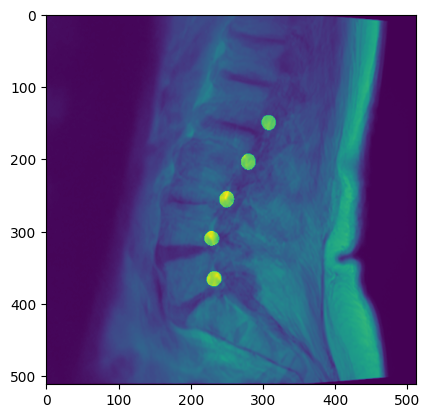

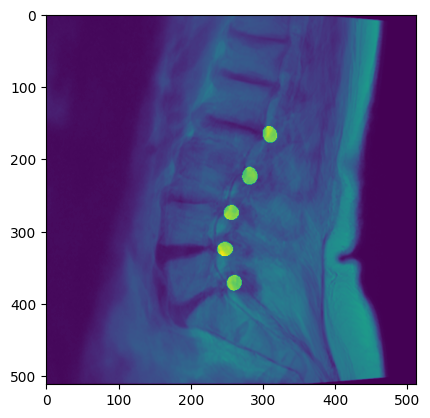

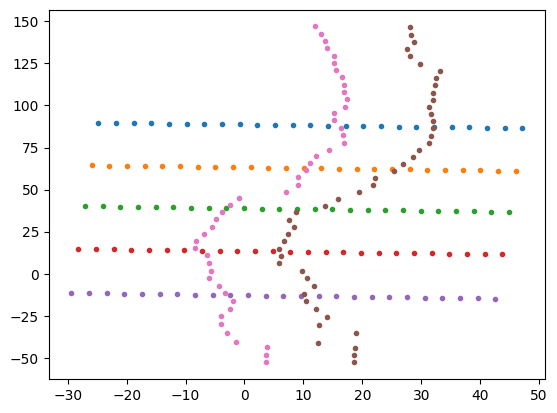

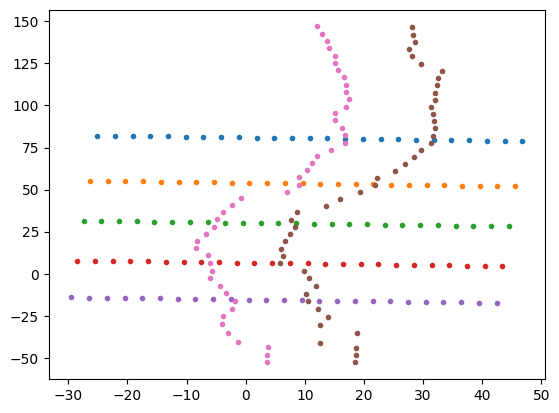

100%|██████████| 1/1 [00:15<00:00, 15.99s/it]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0')


In [9]:
xyz = {}
Axial_T2_xy = {}
Axial_T2_flipped = {}
Axial_T2_assignments = {}
Axial_T2_instance_number = []
T1_study_ids = []
T1_series_ids = []
T1_flipped = []
T1_instance_number = []
T1_levels = []
T2_study_ids = []
T2_series_ids = []
T2_instance_number = []
T2_levels = []
for study_id,df in tqdm(cases):
    Sagittal_T1_df = df[df.series_description == 'Sagittal T1']
    Sagittal_T2_df = df[df.series_description == 'Sagittal T2/STIR']
    Axial_T2_df = df[df.series_description == 'Axial T2']
    
    xyz['Sagittal_T1'] = {}
    xyz['Sagittal_T2'] = {}
    xyz['Axial_T2'] = {}
    
    if len(Sagittal_T1_df) > 0:
        xyz['Sagittal_T1'] = {}
        for k in range(len(Sagittal_T1_df)):
            row = Sagittal_T1_df.iloc[k]
            xyz['Sagittal_T1'][row.series_id] = read_volume(row)
            
    if len(Sagittal_T2_df) > 0:
        xyz['Sagittal_T2'] = {}
        for k in range(len(Sagittal_T2_df)):
            row = Sagittal_T2_df.iloc[k]
            xyz['Sagittal_T2'][row.series_id] = read_volume(row)

    if len(Axial_T2_df) > 0:
        xyz['Axial_T2'] = {}
        Axial_T2_xy[study_id] = {}
        Axial_T2_flipped[study_id] = {}
        Axial_T2_assignments[study_id] = {}
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            for k in range(len(Axial_T2_df)):
                row = Axial_T2_df.iloc[k]
                xyz['Axial_T2'][row.series_id],Axial_T2_xy[study_id][row.series_id] = read_volume(row)
                points = xyz['Axial_T2'][row.series_id][:,:,2].mean(1)
                Axial_T2_flipped[study_id][row.series_id] = points[-1] > points[0]
                Axial_T2_assignments[study_id][row.series_id] = []

    if study_id == cases[0][0]:
        for Sagittal_T1_series in xyz['Sagittal_T1']:
            for l in [0,1,2,3,4]:
                plt.plot(
                    xyz['Sagittal_T1'][Sagittal_T1_series][0][:,l,0],
                    xyz['Sagittal_T1'][Sagittal_T1_series][0][:,l,2],
                    '.'
                )
        for Axial_T2_series in xyz['Axial_T2']:
            for s in [0,1]:
                 plt.plot(
                    xyz['Axial_T2'][Axial_T2_series][:,s,0],
                    xyz['Axial_T2'][Axial_T2_series][:,s,2],
                    '.'
                 )
        plt.show()
        
        for Sagittal_T2_series in xyz['Sagittal_T2']:
            for l in [0,1,2,3,4]:
                plt.plot(
                    xyz['Sagittal_T2'][Sagittal_T2_series][0][:,l,0],
                    xyz['Sagittal_T2'][Sagittal_T2_series][0][:,l,2],
                    '.'
                )
        for Axial_T2_series in xyz['Axial_T2']:
            for s in [0,1]:
                 plt.plot(
                    xyz['Axial_T2'][Axial_T2_series][:,s,0],
                    xyz['Axial_T2'][Axial_T2_series][:,s,2],
                    '.'
                 )
        plt.show()
    
    for Sagittal_T1_series in xyz['Sagittal_T1']:
        T1_study_ids.append(study_id)
        T1_series_ids.append(Sagittal_T1_series)
        T1_levels.append(xyz['Sagittal_T1'][Sagittal_T1_series][1].reshape(-1).tolist())
        sagittal_points = xyz['Sagittal_T1'][Sagittal_T1_series][0][:,:,0].mean(1)
        T1_flipped.append(sagittal_points[-1] < sagittal_points[0])
        
        sagittal_assignments = []
        xxyyzz = torch.as_tensor(xyz['Sagittal_T1'][Sagittal_T1_series][0]).view(1,-1,5,3).to(device)
        for Axial_T2_series in xyz['Axial_T2']:
            points = torch.as_tensor(xyz['Axial_T2'][Axial_T2_series]).to(device)
            points = points.mean(1)
            d = points.view(-1,1,1,3) - xxyyzz
            d = d*d
            d = d.sum(-1)
            level_assignments = torch.argmin(d.min(1)[0],-1)
            if study_id == cases[0][0]: print(level_assignments)           
            for l in [0,1,2,3,4]:
                level_mask = level_assignments == l
                if level_mask.sum() > 0:
                    dd = d[level_mask,:,l]
                    axial_idx,sagittal_idx = torch.where(dd == dd.min())
                    sagittal_assignments.append([l,sagittal_idx[0].item()])
                
        v = torch.zeros(5)
        v[:] = torch.nan
        slices_df = pd.DataFrame(sagittal_assignments).groupby([0]).mean()
        for i in range(len(slices_df)):
            row = slices_df.iloc[i]
            v[
                {
                    0:0,
                    1:1,
                    2:2,
                    3:3,
                    4:4
                }[row.name]
            ] = row.values[0]
    
        v_mean = v.nanmean()
        mask = v.isnan()
        v[mask] = v_mean
        T1_instance_number.append(v.tolist())
        
    for Sagittal_T2_series in xyz['Sagittal_T2']:
        T2_study_ids.append(study_id)
        T2_series_ids.append(Sagittal_T2_series)
        T2_levels.append(xyz['Sagittal_T2'][Sagittal_T2_series][1].reshape(-1).tolist())
        
        sagittal_assignments = []
        xxyyzz = torch.as_tensor(xyz['Sagittal_T2'][Sagittal_T2_series][0]).view(1,-1,5,3).to(device)
        for Axial_T2_series in xyz['Axial_T2']:
            points = torch.as_tensor(xyz['Axial_T2'][Axial_T2_series]).to(device)
            points = points.mean(1)
            axial_indices = torch.arange(len(points)).to(device)
            d = points.view(-1,1,1,3) - xxyyzz
            d = d*d
            d = d.sum(-1)
            level_assignments = torch.argmin(d.min(1)[0],-1)
            Axial_T2_assignments[study_id][Axial_T2_series].append(level_assignments.tolist())
            if study_id == cases[0][0]: print(level_assignments)
            v = torch.zeros(5)
            v[:] = torch.nan
            for l in [0,1,2,3,4]:
                level_mask = level_assignments == l
                if level_mask.sum() > 0:
                    dd = d[level_mask,:,l]
                    axial_idx,sagittal_idx = torch.where(dd == dd.min())
                    sagittal_assignments.append([l,sagittal_idx[0].item()])
                    v[l] = axial_indices[level_mask][axial_idx[0]].item()
            Axial_T2_instance_number.append([study_id,Axial_T2_series]+v.tolist())
                
        v = torch.zeros(5)
        v[:] = torch.nan
        slices_df = pd.DataFrame(sagittal_assignments).groupby([0]).mean()
        for i in range(len(slices_df)):
            row = slices_df.iloc[i]
            v[
                {
                    0:0,
                    1:1,
                    2:2,
                    3:3,
                    4:4
                }[row.name]
            ] = row.values[0]
    
        v_mean = v.nanmean()
        mask = v.isnan()
        v[mask] = v_mean
        T2_instance_number.append(v.tolist())

In [10]:
Axial_T2_instane_number_df = pd.DataFrame(Axial_T2_instance_number).groupby([0,1]).mean().reset_index().rename(columns={
    0:'study_id',
    1:'series_id',
    2:'L1L2',
    3:'L2L3',
    4:'L3L4',
    5:'L4L5',
    6:'L5S1'
})
Axial_T2_instane_number_df.tail()

,study_id,series_id,L1L2,L2L3,L3L4,L4L5,L5S1
0,44036939,3481971518,15.0,22.0,27.0,33.0,38.0


In [11]:
T1_cases = pd.DataFrame(
    {
        'study_id':T1_study_ids,
        'series_id':T1_series_ids,
        'flipped':T1_flipped
    }
)
T1_cases[[
    'L1L2','L2L3','L3L4','L4L5','L5S1'
]] = T1_instance_number
T1_cases[[
    'x_L1L2','y_L1L2',
    'x_L2L3','y_L2L3',
    'x_L3L4','y_L3L4',
    'x_L4L5','y_L4L5',
    'x_L5S1','y_L5S1'
]] = T1_levels
T1_cases.tail()

,study_id,series_id,flipped,L1L2,L2L3,L3L4,L4L5,L5S1,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1
0,44036939,2828203845,True,8.0,9.0,14.0,15.0,13.0,384.569733,187.199555,349.422554,254.867527,312.073333,319.793333,286.088235,387.444853,290.169014,457.426056


In [12]:
T2_cases = pd.DataFrame(
    {
        'study_id':T2_study_ids,
        'series_id':T2_series_ids
    }
)
T2_cases[[
    'L1L2','L2L3','L3L4','L4L5','L5S1'
]] = T2_instance_number
T2_cases[[
    'x_L1L2','y_L1L2',
    'x_L2L3','y_L2L3',
    'x_L3L4','y_L3L4',
    'x_L4L5','y_L4L5',
    'x_L5S1','y_L5S1'
]] = T2_levels
T2_cases.tail()

,study_id,series_id,L1L2,L2L3,L3L4,L4L5,L5S1,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1
0,44036939,3844393089,8.0,10.0,14.0,15.0,13.0,464.018767,249.088472,422.390736,335.123515,383.949438,411.265449,371.075931,487.044413,390.066298,557.096685


In [13]:
if DEBUG:
    T1_cases.to_csv('T1_cases.csv',index=False)
    T2_cases.to_csv('T2_cases.csv',index=False)
    Axial_T2_instane_number_df.to_csv('Axial_T2_instane_number.csv',index=False)
    
    with open('Axial_T2_xy.pkl', 'wb') as handle:
        pickle.dump(Axial_T2_xy, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('Axial_T2_flipped.pkl', 'wb') as handle:
        pickle.dump(Axial_T2_flipped, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('Axial_T2_assignments.pkl', 'wb') as handle:
        pickle.dump(Axial_T2_assignments, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
del models
gc.collect()

7581

# Sagittal T1

In [15]:
Lmax = 10
patch_size = 64
BS = 32

class Sagittal_T1_foraminal_Dataset(Dataset):
    def __init__(self, df, P=patch_size):
        self.data = df
        self.P = P
        self.resize = torchvision.transforms.Resize((PATCH_H,PATCH_W),antialias=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        
        
        sample = TEST_PATH + str(row['study_id']) + '/'+str(row['series_id'])

        images = [x for x in glob.glob(sample+'/*.dcm')]
        images.sort(reverse=False, key=lambda x: int(x.split('/')[-1].replace('.dcm', '')))

        M = row[[
            'L1L2',
            'L2L3',
            'L3L4',
            'L4L5',
            'L5S1'
        ]].values

        image = torch.stack([
            torch.as_tensor(pydicom.dcmread(x).pixel_array.astype(np.float32)) for x in images
        ]).float().to(device)
        image = image/image.max()
        D,H,W = image.shape

        c = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
        missing = c.isnan().sum(1) > 0
        c[missing] = 0

        if H > W:
            d = W
            h = (H - d)//2
            image = image[:,h:h+d]
            c[:,1] -= h
            H = W
        elif H < W:
            d = H
            w = (W - d)//2
            image = image[:,:,w:w+d]
            c[:,0] -= w
            W = H

        image = self.resize(image)
        image = nn.functional.pad(
            image,
            [
                self.P//2, self.P - self.P//2,
                self.P//2, self.P - self.P//2
            ],'reflect')
        c[:,1] = c[:,1]*PATCH_H/H + self.P//2
        c[:,0] = c[:,0]*PATCH_W/W + self.P//2
        c = c.long()

        crops = torch.stack([
            image[
                :,
                xy[1]-self.P//2:xy[1]+self.P-self.P//2,
                xy[0]-self.P//2:xy[0]+self.P-self.P//2
            ] for xy in c
        ])

        image = torch.zeros(2,5,Lmax,self.P,self.P).to(device)
        slices_mask = torch.ones(2,5,Lmax).bool().to(device)
        for i in range(5):
            if ~missing[i]:
                if row.flipped:
                    left_start = int(M[i]) + 1
                    left_end = min([D,left_start + Lmax])
                    left_crop = crops[i,left_start:left_end]

                    right_end = int(M[i])
                    right_start = max([0,right_end - Lmax])
                    right_crop = crops[i,right_start:right_end]

                    image[1,i,:len(left_crop)] = left_crop
                    image[0,i,:len(right_crop)] = right_crop.flip(0)

                    slices_mask[1,i,:len(left_crop)] = False
                    slices_mask[0,i,:len(right_crop)] = False
                else:
                    left_start = int(M[i]) + 1
                    left_end = min([D,left_start + Lmax])
                    left_crop = crops[i,left_start:left_end]

                    right_end = int(M[i])
                    right_start = max([0,right_end - Lmax])
                    right_crop = crops[i,right_start:right_end]

                    image[0,i,:len(left_crop)] = left_crop
                    image[1,i,:len(right_crop)] = right_crop.flip(0)

                    slices_mask[0,i,:len(left_crop)] = False
                    slices_mask[1,i,:len(right_crop)] = False

        return row.study_id,image,missing,slices_mask

In [16]:
ds = Sagittal_T1_foraminal_Dataset(T1_cases)

44036939
tensor([False, False, False, False, False])


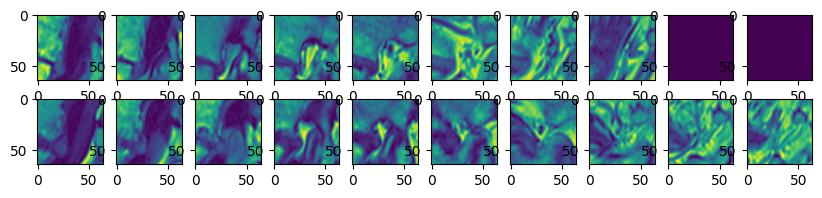

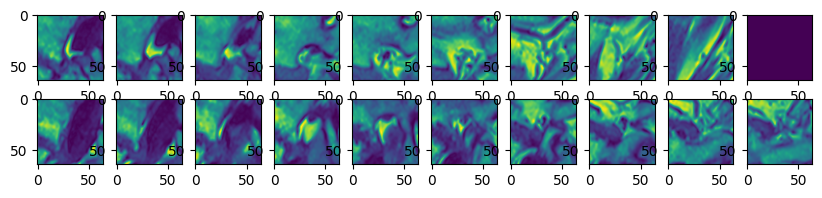

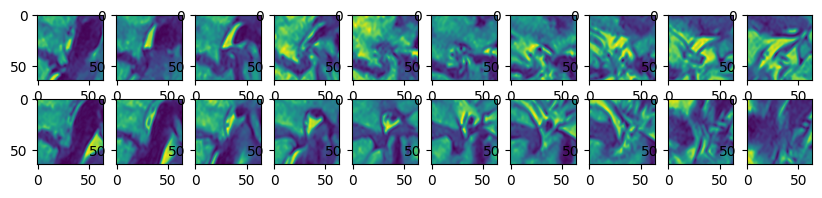

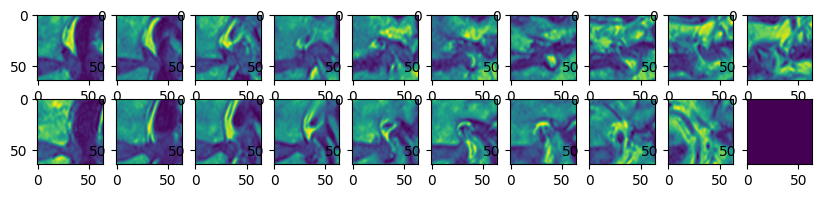

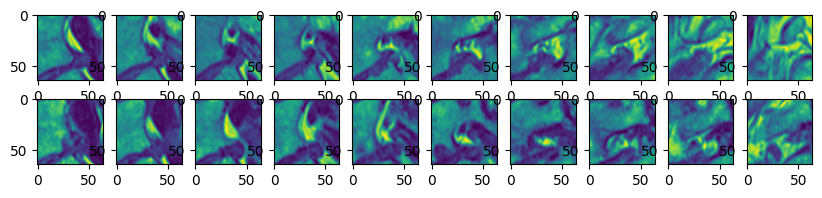

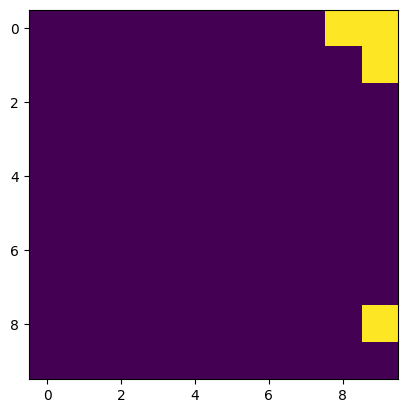

In [17]:
study_id,sample,m,mask = ds.__getitem__(np.random.randint(len(ds)))
print(study_id)
print(m)
for k in range(5):
    fig, axes = plt.subplots(2, Lmax, figsize=(10,2))
    for i in range(2):
        for j in range(Lmax):
            axes[i,j].imshow(sample.cpu()[i,k,j])
    plt.show()

plt.imshow(mask.cpu().view(-1,Lmax))

In [18]:
class Sagittal_T1_Foraminal_ViT(nn.Module):
    def __init__(
            self,
            ENCODER,
            dim=512,
            depth=24,
            head_size=64
        ):
        super().__init__()
        self.ENCODER = ENCODER
        self.slices_enc = SinusoidalPosEmb(dim)(torch.arange(Lmax, device=device).unsqueeze(0))
        pos_enc = SinusoidalPosEmb(dim)(torch.arange(5, device=device).unsqueeze(0))
        self.pos_enc = nn.Parameter(pos_enc)
        self.slices_transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), depth)
        self.transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), depth)
        self.proj_out = nn.Linear(dim,3).to(device)
    
    def forward(self, x):
        x,slices_mask = x
        slices_mask = slices_mask.view(-1,Lmax)
        mask = slices_mask.sum(-1) < Lmax
        
        x = self.ENCODER(x.view(-1,1,patch_size,patch_size))

        x = x.view(-1,Lmax,512)
        x = x + self.slices_enc
        x[mask] = self.slices_transformer(x[mask],src_key_padding_mask=slices_mask[mask])

        x[slices_mask] = 0
        d = (~slices_mask).sum(1).unsqueeze(-1).tile(1,512)
        x = x.sum(1)
        x[d > 0] = x[d > 0]/d[d > 0]

        level_mask = (slices_mask.sum(1) == Lmax).view(-1,10)
        x = x.view(-1,10,512) + torch.concat([self.pos_enc,self.pos_enc],1)
        x = self.transformer(x,src_key_padding_mask=level_mask)
        x = self.proj_out(x.view(-1,512)).view(-1,2,5,3)
        return x

In [19]:
if len(T1_cases) > 0:
    
    foraminal_models = []
    for path in Sagittal_T1_foraminal_paths:
        foraminal_models.append(torch.load(path,map_location=device))
        
    dl = torch.utils.data.DataLoader(ds, batch_size=BS, shuffle=False, drop_last=False)
    
    study_ids = []
    foraminal_predictions = []
    with torch.no_grad():
        OUT = torch.zeros((BS,2,5,3)).to(device)
        for study_id,X,mask,slices_mask in tqdm(dl):
            study_ids = study_ids + study_id.tolist()
            mask = mask.view(-1,1,5).tile(1,2,1)
            OUT[:] = 0
            for model in foraminal_models:
                    y_pred = model([X,slices_mask]).view(-1,2,5,3)
                    OUT[:len(X)] += nn.Softmax(dim=-1)(y_pred)
                    
            OUT[:len(X)] = OUT[:len(X)]/OUT[:len(X)].sum(-1,keepdim=True)
            OUT[:len(X)][mask] = torch.nan

            foraminal_predictions = foraminal_predictions + OUT[:len(X)].tolist()
            
    del ds,foraminal_models,dl,OUT
    gc.collect()

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


In [20]:
foraminal_predictions = torch.as_tensor(foraminal_predictions)
ids = []
for study_id in study_ids:
    ids = ids + [str(study_id) + '_' + d for d in foraminal]

In [21]:
foraminal_predictions = pd.DataFrame({
    'row_id':ids,
    'normal_mild':foraminal_predictions[...,0].flatten(),
    'moderate':foraminal_predictions[...,1].flatten(),
    'severe':foraminal_predictions[...,2].flatten()
})
foraminal_predictions.tail()

,row_id,normal_mild,moderate,severe
5,44036939_right_neural_foraminal_narrowing_l1_l2,0.352102,0.621746,0.026152
6,44036939_right_neural_foraminal_narrowing_l2_l3,0.111641,0.556065,0.332294
7,44036939_right_neural_foraminal_narrowing_l3_l4,0.240653,0.587233,0.172114
8,44036939_right_neural_foraminal_narrowing_l4_l5,0.084252,0.871506,0.044242
9,44036939_right_neural_foraminal_narrowing_l5_s1,0.016973,0.540687,0.442340


# Sagittal T2

In [22]:
Lmax = 15
BS = 1

class Sagittal_T2_Spinal_Dataset(Dataset):
    def __init__(self, df, P=patch_size):
        self.data = df
        self.P = P
        self.resize = torchvision.transforms.Resize((PATCH_H,PATCH_W),antialias=True)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
#       Sanity Check getitem        
        row = self.data.iloc[index]
        try:
            return self.__raw_getitem__(row)
        except:
            image = torch.zeros(2,5,Lmax,self.P,self.P).to(device)
            slices_mask = torch.ones(2,5,Lmax).bool().to(device)
            missing = torch.ones(5).bool()
            return int(row.study_id),image,missing,slices_mask

    def __raw_getitem__(self, row):
                
        sample = TEST_PATH + str(int(row['study_id'])) + '/'+str(int(row['series_id']))

        images = [x for x in glob.glob(sample+'/*.dcm')]
        images.sort(reverse=False, key=lambda x: int(x.split('/')[-1].replace('.dcm', '')))

        image = torch.stack([
            torch.as_tensor(pydicom.dcmread(x).pixel_array.astype(np.float32)) for x in images
        ]).float().to(device)
        image = image/image.max()
        D,H,W = image.shape
        
        instance_numbers = row[[
            'L1L2',
            'L2L3',
            'L3L4',
            'L4L5',
            'L5S1'
        ]].values
        instance_missing = np.isnan(instance_numbers)
        instance_numbers[instance_missing] = D/2

        c = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
        missing = c.isnan().sum(1) > 0
        c[missing,0] = W/2
        c[missing,1] = H/2

        if H > W:
            d = W
            h = (H - d)//2
            image = image[:,h:h+d]
            c[:,1] -= h
            H = W
        elif H < W:
            d = H
            w = (W - d)//2
            image = image[:,:,w:w+d]
            c[:,0] -= w
            W = H

        image = self.resize(image)
        image = nn.functional.pad(
            image,
            [
                self.P//2, self.P - self.P//2,
                self.P//2, self.P - self.P//2
            ],'reflect')
        c[:,1] = c[:,1]*PATCH_H/H + self.P//2
        c[:,0] = c[:,0]*PATCH_W/W + self.P//2
        c = c.long()

        crops = torch.stack([
            image[
                :,
                xy[1]-self.P//2:xy[1]+self.P-self.P//2,
                xy[0]-self.P//2:xy[0]+self.P-self.P//2
            ] for xy in c
        ])

        image = torch.zeros(2,5,Lmax,self.P,self.P).to(device)
        slices_mask = torch.ones(2,5,Lmax).bool().to(device)
        for i in range(5):
            if ~missing[i]:
                instance_number = instance_numbers[i].astype(int)
                start = max([0,instance_number - Lmax//2])
                end = min([D,start + Lmax])
                crop = crops[i,start:end]

                image[0,i,:len(crop)] = crop
                image[1,i,:len(crop)] = crop.flip(0)
                slices_mask[:,i,:len(crop)] = False

        return int(row.study_id),image,missing,slices_mask

In [23]:
ds = Sagittal_T2_Spinal_Dataset(T2_cases)

44036939
tensor([False, False, False, False, False])


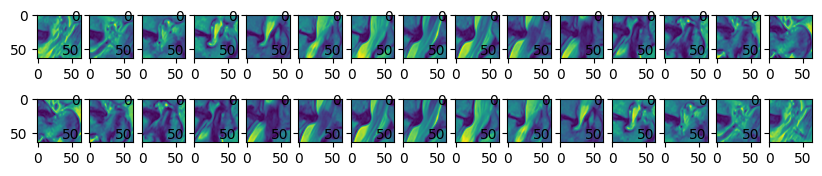

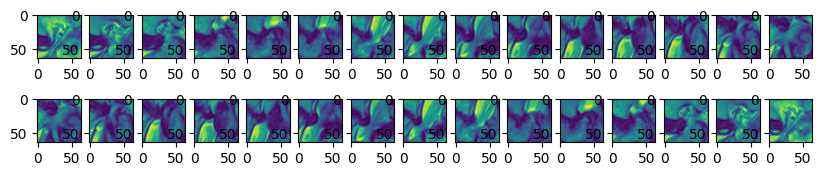

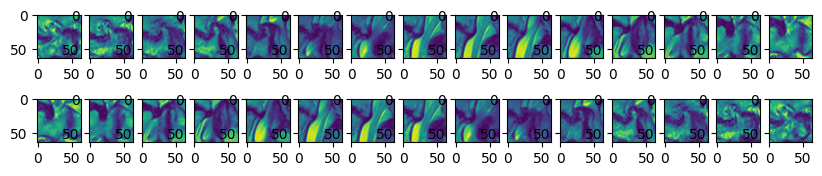

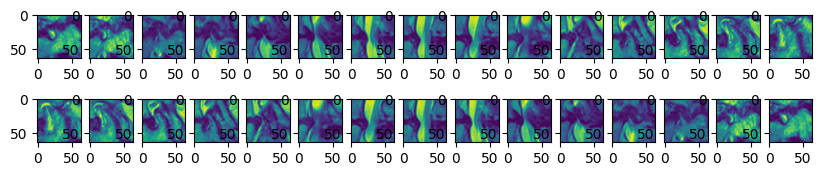

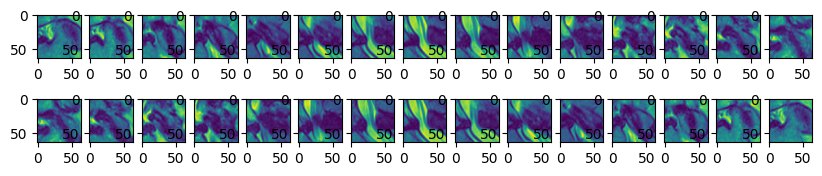

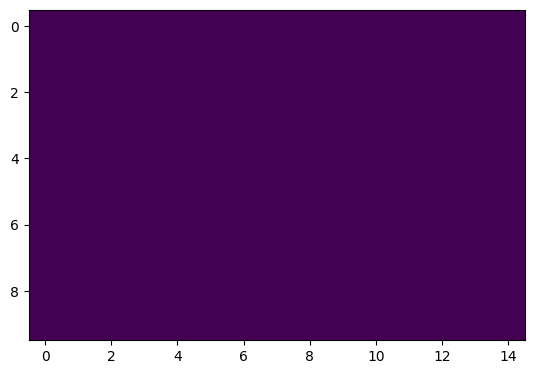

In [24]:
study_id,sample,m,mask = ds.__getitem__(np.random.randint(len(ds)))
print(study_id)
print(m)
for k in range(5):
    fig, axes = plt.subplots(2, Lmax, figsize=(10,2))
    for i in range(2):
        for j in range(Lmax):
            axes[i,j].imshow(sample.cpu()[i,k,j])
    plt.show()

plt.imshow(mask.cpu().view(-1,Lmax))

In [25]:
class Sagittal_T2_spine_Discriminator(nn.Module):
    def __init__(self, dim=512):
        super().__init__()
        CNN = torchvision.models.resnet18(weights='DEFAULT')
        W = nn.Parameter(CNN.conv1.weight.sum(1, keepdim=True))
        CNN.conv1 = nn.Conv2d(1, patch_size, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        CNN.conv1.weight = W
        CNN.fc = nn.Identity()
        self.emb = CNN.to(device)
        self.proj_out = nn.Linear(dim,2).to(device)
    
    def forward(self, x):        
        x = self.emb(x.view(-1,1,patch_size,patch_size))
        x = self.proj_out(x.view(-1,512))
        return x
    
class Sagittal_T2_Spinal_ViT(nn.Module):
    def __init__(
            self,
            ENCODER,
            dim=512,
            depth=24,
            head_size=64
        ):
        super().__init__()
        self.ENCODER = ENCODER
        self.slices_enc = SinusoidalPosEmb(dim)(torch.arange(Lmax, device=device).unsqueeze(0))
        self.slices_enc = nn.Parameter(self.slices_enc)
        pos_enc = SinusoidalPosEmb(dim)(torch.arange(5, device=device).unsqueeze(0))
        self.pos_enc = nn.Parameter(pos_enc)
        self.slices_transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), depth)
        self.transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), depth)
        self.proj_out = nn.Linear(dim,3).to(device)
    
    def forward(self, x):
        x,slices_mask = x
        slices_mask = slices_mask.view(-1,Lmax)
        mask = slices_mask.sum(-1) < Lmax
        
        x = self.ENCODER(x.view(-1,1,patch_size,patch_size))

        x = x.view(-1,Lmax,512)
        x = x + self.slices_enc
        x[mask] = self.slices_transformer(x[mask],src_key_padding_mask=slices_mask[mask])

        x[slices_mask] = 0
        d = (~slices_mask).sum(1).unsqueeze(-1).tile(1,512)
        x = x.sum(1)
        x[d > 0] = x[d > 0]/d[d > 0]

        level_mask = (slices_mask.sum(1) == Lmax).view(-1,5)
        mask = level_mask.sum(-1) < 5
        x = x.view(-1,5,512) + self.pos_enc
        x[mask] = self.transformer(x[mask],src_key_padding_mask=level_mask[mask])
        x = self.proj_out(x.view(-1,512)).view(-1,5,3)
        return x

In [26]:
if len(T2_cases) > 0:
    
    spinal_models = []
    for path in Sagittal_T2_spinal_paths:
        spinal_models.append(torch.load(path,map_location=device))
        
    dl = torch.utils.data.DataLoader(ds, batch_size=BS, shuffle=False, drop_last=False)
    
    study_ids = []
    spinal_predictions = []
    with torch.no_grad():
        OUT = torch.zeros(BS*2,5,3).to(device)
        for study_id,X,mask,slices_mask in tqdm(dl):
            study_ids = study_ids + study_id.tolist()
            OUT[:] = 0
            for model in spinal_models:
                OUT[:len(X)*2] += nn.Softmax(dim=-1)(model([X,slices_mask]))
                    
            OUT[:len(X)*2] = OUT[:len(X)*2]/OUT[:len(X)*2].sum(-1,keepdim=True)
            OUT[:len(X)] = OUT[:len(X)*2].view(-1,2,5,3).mean(1)
            OUT[:len(X)][mask] = torch.nan
            
            spinal_predictions = spinal_predictions + OUT[:len(X)].tolist()
            
    del ds,spinal_models,OUT,dl
    gc.collect()

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


In [27]:
spinal_predictions = torch.as_tensor(spinal_predictions)
ids = []
for study_id in study_ids:
    ids = ids + [str(study_id) + '_' + d for d in spinal]

In [28]:
spinal_predictions = pd.DataFrame({
    'row_id':ids,
    'normal_mild':spinal_predictions[...,0].flatten(),
    'moderate':spinal_predictions[...,1].flatten(),
    'severe':spinal_predictions[...,2].flatten()
})
spinal_predictions.tail()

,row_id,normal_mild,moderate,severe
0,44036939_spinal_canal_stenosis_l1_l2,0.462823,0.528666,0.008511
1,44036939_spinal_canal_stenosis_l2_l3,0.017223,0.352623,0.630155
2,44036939_spinal_canal_stenosis_l3_l4,0.660904,0.335648,0.003448
3,44036939_spinal_canal_stenosis_l4_l5,0.290703,0.625723,0.083574
4,44036939_spinal_canal_stenosis_l5_s1,0.285167,0.540238,0.174595


# Axial T2

In [29]:
id_df = test_description
valid_id = id_df.study_id.unique()

  0%|          | 0/1 [00:00<?, ?it/s]

assigned_level: [5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 3 3 3 3 3 3 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]


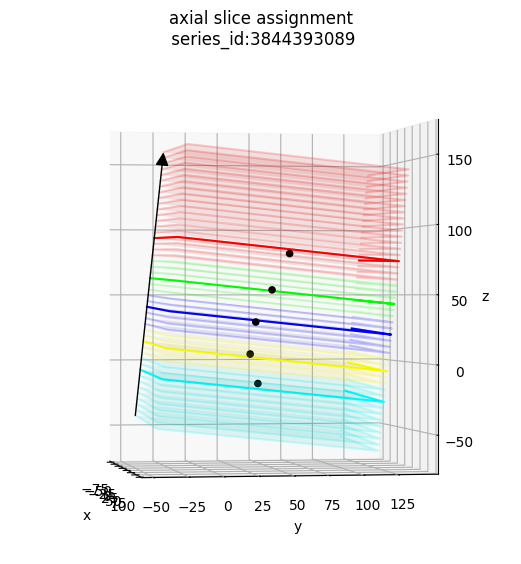

100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


In [30]:
assignments = {}
for i in tqdm(range(len(T2_cases))):
    row = T2_cases.iloc[i]
    study_id = int(row['study_id'])
    axial_t2_ids    = id_df[(id_df.study_id == int(row['study_id'])) & (id_df.series_description=='Axial T2')].series_id
    sagittal_t2_id = int(row['series_id'])
    for axial_t2_id in axial_t2_ids:
        try:
                sagittal_t2_point = torch.as_tensor([x for x in row[[
                    'x_L1L2',
                    'y_L1L2',
                    'x_L2L3',
                    'y_L2L3',
                    'x_L3L4',
                    'y_L3L4',
                    'x_L4L5',
                    'y_L4L5',
                    'x_L5S1',
                    'y_L5S1'
                ]]]).view(5,2).float()


                data = read_study(study_id, axial_t2_id=axial_t2_id, sagittal_t2_id=sagittal_t2_id, test=TEST)


                #--- step.1 : detect 2d point in sagittal_t2
                sagittal_t2 = data.sagittal_t2.volume
                sagittal_t2_df = data.sagittal_t2.df
                axial_t2_df = data.axial_t2.df

                D,H,W = sagittal_t2.shape
                
                sagittal_t2_point[:,0] = sagittal_t2_point[:,0]*256/W
                sagittal_t2_point[:,1] = sagittal_t2_point[:,1]*256/H
                
                sagittal_t2_z = D//2            

                #for debug and development
                point_hat, z_hat = sagittal_t2_point_hat = get_true_sagittal_t2_point(study_id, sagittal_t2_df)
                point_hat = point_hat*[[256/W, 256/H]]


                #--- step.2 : perdict slice level of axial_t2
                world_point = view_to_world(sagittal_t2_point, sagittal_t2_z, sagittal_t2_df, 256)
                assigned_level, closest_z, dis  = axial_t2_level = point_to_level(world_point, axial_t2_df)
                
                key = str(study_id)+'_'+str(sagittal_t2_id)+'_'+str(axial_t2_id)
                assignments[key] = {1:{},2:{},3:{},4:{},5:{}}
                for k in range(5):
                    assignments[key][k + 1]['dis'] = dis[k][assigned_level == k + 1]
                    assignments[key][k + 1]['instance_numbers'] = axial_t2_df.instance_number[assigned_level == k + 1].values

                if i == 0:
                    print('assigned_level:', assigned_level)
                    ###################################################################
                    #visualisation
                    # https://matplotlib.org/stable/gallery/mplot3d/mixed_subplots.html
                    fig = plt.figure(figsize=(23, 6))
                    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

                    # draw  assigned_level
                    level_ncolor = np.array(level_color) / 255
                    coloring = level_ncolor[assigned_level].tolist()
                    draw_slice(
                        ax2, axial_t2_df,
                        is_slice=True,   scolor=coloring, salpha=[0.1],
                        is_border=True,  bcolor=coloring, balpha=[0.2],
                        is_origin=False, ocolor=[[0, 0, 0]], oalpha=[0.0],
                        is_arrow=True
                    )

                    # draw world_point
                    ax2.scatter(world_point[:, 0], world_point[:, 1], world_point[:, 2], alpha=1, color='black')


                    ### draw closest slice
                    coloring = level_ncolor[1:].tolist()
                    draw_slice(
                        ax2, axial_t2_df.iloc[closest_z],
                        is_slice=True, scolor=coloring, salpha=[0.1],
                        is_border=True, bcolor=coloring, balpha=[1],
                        is_origin=False, ocolor=[[1, 0, 0]], oalpha=[0],
                        is_arrow=False
                    )

                    ax2.set_aspect('equal')
                    ax2.set_title(f'axial slice assignment\n series_id:{sagittal_t2_id}')
                    ax2.set_xlabel('x')
                    ax2.set_ylabel('y')
                    ax2.set_zlabel('z')
                    ax2.view_init(elev=0, azim=-10, roll=0)
                    plt.tight_layout(pad=2)
                    plt.show()
        
        except:
            print(study_id,sagittal_t2_id,axial_t2_id)

In [31]:
df = pd.DataFrame({'key':assignments.keys()})
df['study_id'] = df['key'].apply(lambda v:int(v.split('_')[0]))
df['series_id'] = df['key'].apply(lambda v:int(v.split('_')[-1]))
df.tail()

,key,study_id,series_id
0,44036939_3844393089_3481971518,44036939,3481971518


In [32]:
class subarticular_Dataset(Dataset):
    def __init__(self, df, P=patch_size):
        self.data = df
        self.P = P
        self.resize = torchvision.transforms.Resize((PATCH_SIZE,PATCH_SIZE),antialias=True)
        self.indices = torch.arange(Lmax).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        row = self.data.iloc[index]
        
        sample = TEST_PATH+str(int(row['study_id']))+'/'+str(int(row['series_id']))

        images = [x for x in glob.glob(sample+'/*.dcm')]
        images.sort(key=lambda k:int(k.split('/')[-1].replace('.dcm','')))
        instance_numbers = [int(k.split('/')[-1].replace('.dcm','')) for k in images]
        images = [torch.as_tensor(pydicom.dcmread(img).pixel_array.astype('float32')) for img in images]
        shapes = [img.shape for img in images]
        H,W = np.array(shapes).max(0)
        
        centers = torch.as_tensor(coord[row['study_id']][row['series_id']]).clone().float()
        levels = torch.as_tensor(Axial_T2_assignments[row['study_id']][row['series_id']]).float().mean(0).long()
        
        for l in range(5):
            mask = levels == l
            if mask.sum() > 0:
                level_mean = centers[mask].nanmean(0).view(1,2,2).tile(mask.sum(),1,1)
                missing = centers[mask].isnan()
                centers[mask][missing] = level_mean[missing]

        centers_mean = centers.nanmean(0).view(1,2,2).tile(len(centers),1,1)
        missing = centers.isnan()
        centers[missing] = centers_mean[missing]
        
        c=centers
        for k in range(len(c)):
            h,w = shapes[k]
            c[k,0] += (W - w)//2
            c[k,1] += (H - h)//2

        images = torch.concat([torch.nn.functional.pad(
            images[k].unsqueeze(0),(
                (W - shapes[k][-1])//2,
                (W - shapes[k][-1]) - (W - shapes[k][-1])//2,
                (H - shapes[k][-2])//2,
                (H - shapes[k][-2]) - (H - shapes[k][-2])//2
            ),
        mode='reflect') for k in range(len(images))]).float()

        if H > W:
            d = W
            h = (H - d)//2
            c[:,1] -= h
            images = images[:,h:h+d]
            H = W
        elif H < W:
            d = H
            w = (W - d)//2
            c[:,0] -= w
            images = images[:,:,w:w+d]
            W = H
            
        c[:,0] = c[:,0]*PATCH_SIZE/W
        c[:,1] = c[:,1]*PATCH_SIZE/H

        images = self.resize(images/images.max()).float().to(device)

        c[c < 64] = torch.nan
        c[c > 512 - 64] = torch.nan
        c_mean = torch.nanmean(c, dim=0)
        instance_to_k = {instance_numbers[k]:k for k in range(len(c))}
        
        img = torch.zeros(5,2,Lmax,self.P,self.P)
        slices_mask = torch.ones(5,2,Lmax).bool()
        for k in [1,2,3,4,5]:
            instance_numbers = assignments[row['key']][k]['instance_numbers']
            if len(instance_numbers) == 0: continue
            distances = assignments[row['key']][k]['dis']
            dis_sign = np.sign(distances)
            if dis_sign[0] != dis_sign[-1]:
                c_k = torch.stack([c[instance_to_k[i]] for i in instance_numbers])
                c_k_mean = torch.nanmean(c_k, dim=0)
                mask =  torch.isnan(c_k_mean)
                c_k_mean[mask] = c_mean[mask]
                for i in instance_numbers:
                    mask = torch.isnan(c[instance_to_k[i]])
                    c[instance_to_k[i],mask] = c_k_mean[mask]
        
                images_k = torch.stack([
                    torch.stack([
                        images[
                            instance_to_k[i],
                            c[instance_to_k[i],0,1].long()-self.P//2:c[instance_to_k[i],0,1].long()+self.P-self.P//2,
                            c[instance_to_k[i],0,0].long()-self.P//2:c[instance_to_k[i],0,0].long()+self.P-self.P//2
                        ] for i in instance_numbers
                    ]),
                    torch.stack([
                        images[
                            instance_to_k[i],
                            c[instance_to_k[i],1,1].long()-self.P//2:c[instance_to_k[i],1,1].long()+self.P-self.P//2,
                            c[instance_to_k[i],1,0].long()-self.P//2:c[instance_to_k[i],1,0].long()+self.P-self.P//2
                        ] for i in instance_numbers
                    ]).flip(-1)
                ])

                if len(distances) > Lmax:
                    indices = [i for i in range(len(distances))]
                    indices.sort(key=lambda i:abs(distances[i]))
                    indices = indices[:Lmax]
                    indices.sort()
                    img[k-1] = images_k[:,indices]
                    slices_mask[k-1] = False

                else:
                    d = (Lmax - len(distances))//2
                    img[k-1,:,d:d+len(distances)] = images_k
                    slices_mask[k-1,:,d:d+len(distances)] = False

        return torch.as_tensor(int(row['study_id'])).to(device),img.to(device),slices_mask.to(device)

In [33]:
PATCH_SIZE = 512
coord = Axial_T2_xy
ds = subarticular_Dataset(df)

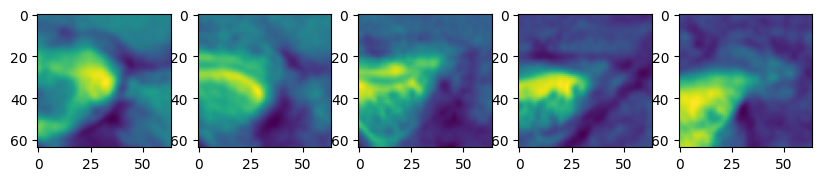

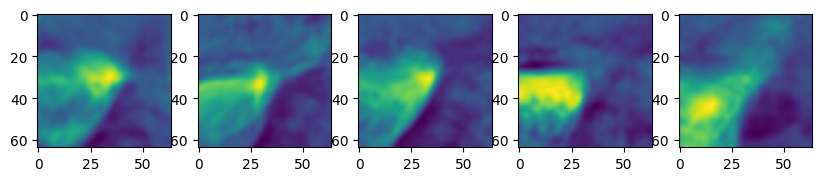

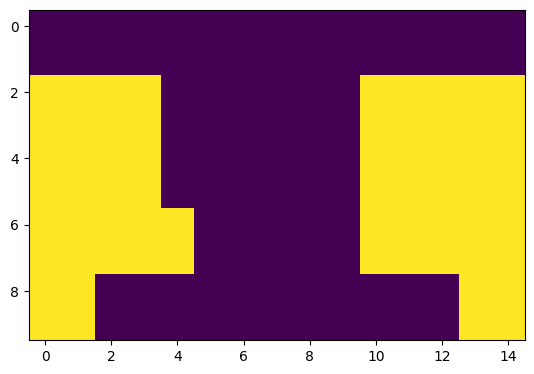

In [34]:
sample = ds.__getitem__(np.random.randint(len(ds)))
fig, axesL = plt.subplots(1, 5, figsize=(10,10))
fig, axesR = plt.subplots(1, 5, figsize=(10,10))
for k in range(5):
    axesL[k].imshow(sample[1][k,0].sum(0).cpu())
    axesR[k].imshow(sample[1][k,1].sum(0).cpu())
plt.show()
plt.imshow(sample[2].cpu().view(-1,Lmax))
plt.show()

In [35]:
# Old version
class myUNet(nn.Module):
    def __init__(self):
        super(myUNet, self).__init__()

        self.UNet = smp.Unet(
            encoder_name="resnet18",
            classes=2,
            in_channels=1
        ).to(device)

    def forward(self,X):
        x = self.UNet(X)
#       MinMaxScaling along the class plane to generate a heatmap
        min_values = x.view(-1,2,PATCH_SIZE*PATCH_SIZE).min(-1)[0].view(-1,2,1,1)
        max_values = x.view(-1,2,PATCH_SIZE*PATCH_SIZE).max(-1)[0].view(-1,2,1,1)
        x = (x - min_values)/(max_values - min_values)
        
        return x

In [36]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim=16, M=10000):
        super().__init__()
        self.dim = dim
        self.M = M

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.M) / half_dim
        emb = torch.exp(torch.arange(half_dim, device=device) * (-emb))
        emb = x[...,None] * emb[None,...]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class myViT(nn.Module):
    def __init__(self, ENCODER, dim=512, depth=24, head_size=64, **kwargs):
        super().__init__()
        self.ENCODER = ENCODER
        self.AvgPool = nn.AdaptiveAvgPool2d(output_size=1).to(device)
        self.slices_pos_enc = nn.Parameter(SinusoidalPosEmb(dim)(torch.arange(Lmax, device=device).unsqueeze(0)))
        self.side_pos_enc = nn.Parameter(SinusoidalPosEmb(dim)(torch.arange(2, device=device).unsqueeze(0)))
        self.level_pos_enc = nn.Parameter(SinusoidalPosEmb(dim)(torch.arange(5, device=device).unsqueeze(0)))
        self.slices_transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), 24)
        self.side_transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), 12)
        self.level_transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), 12)
        self.proj_out = nn.Linear(dim,3).to(device)
    
    def forward(self, x):
        x,slices_mask = x
        
        x = self.ENCODER(x.view(-1,1,patch_size,patch_size))[-1]
        x = self.AvgPool(x)
        slices_mask = slices_mask.view(-1,Lmax)
        mask = slices_mask.sum(-1) < Lmax
        x = x.view(-1,Lmax,512) + self.slices_pos_enc
        x[mask] = self.slices_transformer(x[mask],src_key_padding_mask=slices_mask[mask])
        x[slices_mask] = 0
        d = (~slices_mask).sum(1).unsqueeze(-1).tile(1,512)
        x = x.sum(1)
        x[d > 0] = x[d > 0]/d[d > 0]

        side_mask = slices_mask.view(-1,2,Lmax).sum(-1) == Lmax
        mask = side_mask.sum(-1) < 2
        x = x.view(-1,2,512) + self.side_pos_enc
        x[mask] = self.side_transformer(x[mask],src_key_padding_mask=side_mask[mask])

        level_mask = side_mask.view(-1,5,2).permute(0,2,1).reshape(-1,5)
        mask = level_mask.sum(-1) < 5
        x = x.view(-1,5,2,512).permute(0,2,1,3).reshape(-1,5,512)
        x = x + self.level_pos_enc
        x[mask] = self.level_transformer(x[mask],src_key_padding_mask=level_mask[mask])

        x = self.proj_out(x.reshape(-1,512)).view(-1,2,5,3)

        return x

In [37]:
if len(df) > 0:
    
    Lmax = 5
    BS = 2
    
    subarticular_models = []
    for path in Axial_T2_subarticular_paths:
        subarticular_models.append(torch.load(path,map_location=device))
        
    dl = torch.utils.data.DataLoader(ds, batch_size=BS, shuffle=False, drop_last=False)
    
    OUT = torch.zeros((BS*10,3)).to(device)
    fOUT = torch.zeros((BS*10,3)).to(device)
    
    with torch.no_grad():
        study_ids = []
        subarticular_predictions = []
        for study_id,X,mask in tqdm(dl):
            UNK = (mask.sum(-1) == Lmax).permute(0,2,1).reshape(-1,10)
            study_ids = study_ids + study_id.tolist()
            OUT[:] = 0
            fOUT[:] = 0
            for model in subarticular_models:
                    OUT[:len(X)*10] += nn.Softmax(dim=-1)(model([X,mask]).view(-1,3))
                    fOUT[:len(X)*10] += nn.Softmax(dim=-1)(model([X.flip(2),mask]).view(-1,3))
                    
            OUT[:len(X)*10] = (OUT[:len(X)*10]/OUT[:len(X)*10].sum(-1,keepdim=True))
            fOUT[:len(X)*10] = (fOUT[:len(X)*10]/fOUT[:len(X)*10].sum(-1,keepdim=True))
            PREDS = OUT.view(-1,10,3)[:len(X)]
            fPREDS = fOUT.view(-1,10,3)[:len(X)]
            PREDS[:,5:] += fPREDS[:,:5]
            PREDS[:,:5] += fPREDS[:,5:]
            PREDS /= 2
            PREDS[UNK] = torch.nan#1./3
            
            subarticular_predictions = subarticular_predictions + PREDS.tolist()
            
    del ds,subarticular_models,dl,OUT
    gc.collect()

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


In [38]:
subarticular_predictions = torch.as_tensor(subarticular_predictions)
ids = []
for study_id in study_ids:
    ids = ids + [str(study_id) + '_' + d for d in subarticular]

In [39]:
subarticular_predictions = pd.DataFrame({
    'row_id':ids,
    'normal_mild':subarticular_predictions[...,0].flatten(),
    'moderate':subarticular_predictions[...,1].flatten(),
    'severe':subarticular_predictions[...,2].flatten()
})
subarticular_predictions.tail()

,row_id,normal_mild,moderate,severe
5,44036939_right_subarticular_stenosis_l1_l2,0.245908,0.637207,0.116886
6,44036939_right_subarticular_stenosis_l2_l3,0.127047,0.629513,0.243440
7,44036939_right_subarticular_stenosis_l3_l4,0.272445,0.594717,0.132838
8,44036939_right_subarticular_stenosis_l4_l5,0.132372,0.524890,0.342738
9,44036939_right_subarticular_stenosis_l5_s1,0.166004,0.522341,0.311655


In [40]:
angle = -60
theta = (angle/180.) * np.pi

rotMatrix = torch.as_tensor([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
]).float().to(device)

In [41]:
class spinal_Axial_Dataset(Dataset):
    def __init__(self, df, P=patch_size):
        self.data = df
        self.P = P
        self.resize = torchvision.transforms.Resize((PATCH_SIZE,PATCH_SIZE),antialias=True)
        self.indices = torch.arange(Lmax).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        row = self.data.iloc[index]
        
        sample = TEST_PATH+str(int(row['study_id']))+'/'+str(int(row['series_id']))

        images = [x.replace('\\','/') for x in glob.glob(sample+'/*.dcm')]
        images.sort(key=lambda k:int(k.split('/')[-1].replace('.dcm','')))
        instance_numbers = [int(k.split('/')[-1].replace('.dcm','')) for k in images]
        images = [torch.as_tensor(pydicom.dcmread(img).pixel_array.astype('float32')) for img in images]
        shapes = [img.shape for img in images]
        H,W = np.array(shapes).max(0)

        centers = torch.as_tensor(coord[row['study_id']][row['series_id']]).clone().float().to(device)
        levels = torch.as_tensor(Axial_T2_assignments[row['study_id']][row['series_id']]).float().mean(0).long()
        
        for l in range(5):
            mask = levels == l
            if mask.sum() > 0:
                level_mean = centers[mask].nanmean(0).view(1,2,2).tile(mask.sum(),1,1)
                missing = centers[mask].isnan()
                centers[mask][missing] = level_mean[missing]

        centers_mean = centers.nanmean(0).view(1,2,2).tile(len(centers),1,1)
        missing = centers.isnan()
        centers[missing] = centers_mean[missing]
        
        c=centers
        for k in range(len(c)):
            h,w = shapes[k]
            c[k,0] += (W - w)//2
            c[k,1] += (H - h)//2

        images = torch.concat([torch.nn.functional.pad(
            images[k].unsqueeze(0),(
                (W - shapes[k][-1])//2,
                (W - shapes[k][-1]) - (W - shapes[k][-1])//2,
                (H - shapes[k][-2])//2,
                (H - shapes[k][-2]) - (H - shapes[k][-2])//2
            ),
        mode='reflect') for k in range(len(images))]).float()

        if H > W:
            d = W
            h = (H - d)//2
            c[:,1] -= h
            images = images[:,h:h+d]
            H = W
        elif H < W:
            d = H
            w = (W - d)//2
            c[:,0] -= w
            images = images[:,:,w:w+d]
            W = H
            
        c[:,0] = c[:,0]*PATCH_SIZE/W
        c[:,1] = c[:,1]*PATCH_SIZE/H

        images = self.resize(images/images.max()).float().to(device)

        c = torch.cat([
            c,
            (c[:,1] + torch.matmul(c[:,0] - c[:,1],rotMatrix)).unsqueeze(1)
        ],1)

        c[c < 64] = torch.nan
        c[c > 512 - 64] = torch.nan

        c_mean = torch.nanmean(c, dim=0)
        instance_to_k = {instance_numbers[k]:k for k in range(len(c))}
        
        img = torch.zeros(5,Lmax,self.P,self.P)
        slices_mask = torch.ones(5,Lmax).bool()
        for k in [1,2,3,4,5]:
            instance_numbers = assignments[row['key']][k]['instance_numbers']
            if len(instance_numbers) == 0: continue
            distances = assignments[row['key']][k]['dis']
            dis_sign = np.sign(distances)
            if dis_sign[0] != dis_sign[-1]:
                c_k = torch.stack([c[instance_to_k[i]] for i in instance_numbers])
                c_k_mean = torch.nanmean(c_k, dim=0)
                mask =  torch.isnan(c_k_mean)
                c_k_mean[mask] = c_mean[mask]
                c_k_mean = c_k_mean.unsqueeze(0).tile(len(c_k),1,1)
                mask = torch.isnan(c_k)
                c_k[mask] = c_k_mean[mask]
                    
                c_spine = c_k.mean(1)
        
                images_k = torch.stack([
                        images[
                            instance_to_k[instance_numbers[i]],
                            c_spine[i,1].long()-self.P//2:c_spine[i,1].long()+self.P-self.P//2,
                            c_spine[i,0].long()-self.P//2:c_spine[i,0].long()+self.P-self.P//2
                        ] for i in range(len(distances))#instance_numbers
                ])

                if len(distances) > Lmax:
                    indices = [i for i in range(len(distances))]
                    indices.sort(key=lambda i:abs(distances[i]))
                    indices = indices[:Lmax]
                    indices.sort()
                    img[k-1] = images_k[indices]
                    slices_mask[k-1] = False

                else:
                    d = (Lmax - len(distances))//2
                    img[k-1,d:d+len(distances)] = images_k
                    slices_mask[k-1,d:d+len(distances)] = False

        return torch.as_tensor(int(row['study_id'])).to(device),img.to(device),slices_mask.to(device)

In [42]:
ds = spinal_Axial_Dataset(df)

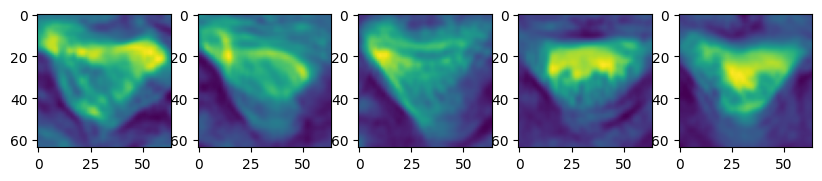

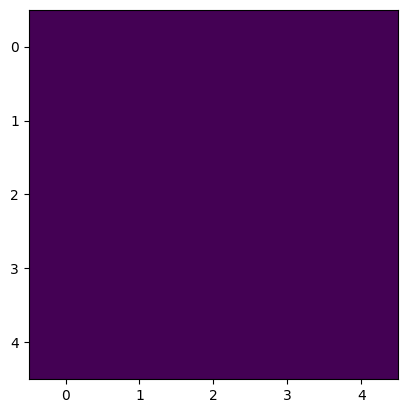

In [43]:
sample = ds.__getitem__(np.random.randint(len(ds)))
fig, axes = plt.subplots(1, 5, figsize=(10,10))
for k in range(5):
    axes[k].imshow(sample[1][k].sum(0).cpu())
plt.show()
plt.imshow(sample[2].cpu().view(-1,Lmax))
plt.show()

In [44]:
class AxialSpinalViT(nn.Module):
    def __init__(
        self,
        ENCODER,
        slices_pos_enc,
        level_pos_enc,
        slices_transformer,
        level_transformer,
        proj_out,
        dim=512, depth=24, head_size=64, **kwargs
    ):
        super().__init__()
        self.ENCODER = ENCODER
        self.AvgPool = nn.AdaptiveAvgPool2d(output_size=1).to(device)
        self.slices_pos_enc = slices_pos_enc
        self.level_pos_enc = level_pos_enc
        self.slices_transformer = slices_transformer
        self.level_transformer = level_transformer
        self.proj_out = proj_out
    
    def forward(self, x):
        x,slices_mask = x
    
        x = self.ENCODER(x.view(-1,1,patch_size,patch_size))[-1]
        x = self.AvgPool(x)
        slices_mask = slices_mask.view(-1,Lmax)
        mask = slices_mask.sum(-1) < Lmax
        x = x.view(-1,Lmax,512) + self.slices_pos_enc
        x[mask] = self.slices_transformer(x[mask],src_key_padding_mask=slices_mask[mask])
        x[slices_mask] = 0
        d = (~slices_mask).sum(1).unsqueeze(-1).tile(1,512)
        x = x.sum(1)
        x[d > 0] = x[d > 0]/d[d > 0]

        level_mask = slices_mask.view(-1,5,Lmax).sum(-1) == Lmax
        mask = level_mask.sum(-1) < 5
        x = x.view(-1,5,512) + self.level_pos_enc
        x[mask] = self.level_transformer(x[mask],src_key_padding_mask=level_mask[mask])

        x = self.proj_out(x.view(-1,512)).view(-1,5,3)

        return x

In [45]:
if len(df) > 0:
    
    spinal_Axial_models = []
    for path in Axial_T2_spinal_paths:
        sub_model = torch.load('/kaggle/input/subarticular-dicom-v2-vit/subarticular_DICOM_V2_ViT_1')
        model = AxialSpinalViT(
            sub_model.ENCODER,
            sub_model.slices_pos_enc,
            sub_model.level_pos_enc,
            sub_model.slices_transformer,
            sub_model.level_transformer,
            sub_model.proj_out
        )
        model.load_state_dict(torch.load(path,map_location=device))#torch.load(PATH), weights_only=True)
        model.eval()
        spinal_Axial_models.append(model)
        
    dl = torch.utils.data.DataLoader(ds, batch_size=BS, shuffle=False, drop_last=False)
    
    OUT = torch.zeros((BS*5,3)).to(device)
    fOUT = torch.zeros((BS*5,3)).to(device)
    
    with torch.no_grad():
        study_ids = []
        Axial_T2_spinal_predictions = []
        for study_id,X,mask in tqdm(dl):
            UNK = mask.view(-1,5,Lmax).sum(-1) == Lmax
            study_ids = study_ids + study_id.tolist()
            OUT[:] = 0
            fOUT[:] = 0
            for model in spinal_Axial_models:
                    OUT[:len(X)*5] += nn.Softmax(dim=-1)(model([X,mask]).view(-1,3))
                    fOUT[:len(X)*5] += nn.Softmax(dim=-1)(model([X.flip(-1),mask]).view(-1,3))
                    
            OUT[:len(X)*5] = (OUT[:len(X)*5]/OUT[:len(X)*5].sum(-1,keepdim=True))
            fOUT[:len(X)*5] = (fOUT[:len(X)*5]/fOUT[:len(X)*5].sum(-1,keepdim=True))
            PREDS = OUT.view(-1,5,3)[:len(X)]
            fPREDS = fOUT.view(-1,5,3)[:len(X)]
            PREDS += fPREDS
            PREDS /= 2
            PREDS[UNK] = torch.nan#1./3

            Axial_T2_spinal_predictions = Axial_T2_spinal_predictions + PREDS.tolist()
            
    del ds,spinal_Axial_models,dl,OUT
    gc.collect()

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


In [46]:
Axial_T2_spinal_predictions = torch.as_tensor(Axial_T2_spinal_predictions)
ids = []
for study_id in study_ids:
    ids = ids + [str(study_id) + '_' + d for d in spinal]

In [47]:
Axial_T2_spinal_predictions = pd.DataFrame({
    'row_id':ids,
    'normal_mild':Axial_T2_spinal_predictions[...,0].flatten(),
    'moderate':Axial_T2_spinal_predictions[...,1].flatten(),
    'severe':Axial_T2_spinal_predictions[...,2].flatten()
})
Axial_T2_spinal_predictions.tail()

,row_id,normal_mild,moderate,severe
0,44036939_spinal_canal_stenosis_l1_l2,0.846499,0.126099,0.027403
1,44036939_spinal_canal_stenosis_l2_l3,0.377132,0.371175,0.251693
2,44036939_spinal_canal_stenosis_l3_l4,0.640579,0.312141,0.047280
3,44036939_spinal_canal_stenosis_l4_l5,0.791907,0.183010,0.025083
4,44036939_spinal_canal_stenosis_l5_s1,0.675854,0.280357,0.043790


# Submission

In [48]:
submission = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv')
submission.tail()

,row_id,normal_mild,moderate,severe
20,44036939_spinal_canal_stenosis_l1_l2,0.333333,0.333333,0.333333
21,44036939_spinal_canal_stenosis_l2_l3,0.333333,0.333333,0.333333
22,44036939_spinal_canal_stenosis_l3_l4,0.333333,0.333333,0.333333
23,44036939_spinal_canal_stenosis_l4_l5,0.333333,0.333333,0.333333
24,44036939_spinal_canal_stenosis_l5_s1,0.333333,0.333333,0.333333


In [49]:
predictions = pd.concat([
    foraminal_predictions,
    spinal_predictions,
    subarticular_predictions,
    Axial_T2_spinal_predictions
]).groupby('row_id').mean().reset_index()
predictions.tail()

,row_id,normal_mild,moderate,severe
20,44036939_spinal_canal_stenosis_l1_l2,0.654661,0.327382,0.017957
21,44036939_spinal_canal_stenosis_l2_l3,0.197177,0.361899,0.440924
22,44036939_spinal_canal_stenosis_l3_l4,0.650741,0.323895,0.025364
23,44036939_spinal_canal_stenosis_l4_l5,0.541305,0.404366,0.054328
24,44036939_spinal_canal_stenosis_l5_s1,0.480510,0.410297,0.109193


In [50]:
submission = pd.DataFrame(submission['row_id']).merge(predictions,left_on='row_id',right_on='row_id',how='left').fillna(1./3)
v = submission[['normal_mild','moderate','severe']].values
v = v/v.sum(1).reshape(-1,1)
submission[['normal_mild','moderate','severe']] = v
submission

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.815726,0.182338,0.001936
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.122837,0.658122,0.219041
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.012129,0.410163,0.577709
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.000807,0.122162,0.877031
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.100364,0.567454,0.332182
5,44036939_left_subarticular_stenosis_l1_l2,0.617266,0.359314,0.023420
6,44036939_left_subarticular_stenosis_l2_l3,0.052119,0.420281,0.527600
7,44036939_left_subarticular_stenosis_l3_l4,0.016581,0.214920,0.768499
8,44036939_left_subarticular_stenosis_l4_l5,0.042481,0.438029,0.519489
9,44036939_left_subarticular_stenosis_l5_s1,0.077611,0.477802,0.444588


In [51]:
submission.to_csv('submission.csv',index=False)